In [1]:
import json
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings("ignore")
DATA_FILE_PATH = './rawdata/Location History.json'

In [2]:
def read_location_data(loc_data_file_path, top_field=None):
    """
    Reads the json data file and returns a Pandas 
    dataframe with the fields as columns. If a top_field
    is provided the dataframe is constructed only using data
    in the top_field.
    """
    raw_data = pd.read_json(loc_data_file_path)
    with open(DATA_FILE_PATH) as fp:
        raw_data = json.load(fp)
        if top_field:
            df = pd.DataFrame(raw_data[top_field])
        else:
            df = pd.DataFrame(raw_data)
        return df
    
    return None


In [3]:
loc_data = read_location_data(DATA_FILE_PATH, top_field='locations')
loc_data['latitude'] = loc_data['latitudeE7'] / (10**7)
loc_data['longitude'] = loc_data['longitudeE7'] / (10**7)
loc_data.drop(['latitudeE7', 'longitudeE7'], axis=1, inplace=True)
loc_data.describe()

,accuracy,altitude,heading,velocity,verticalAccuracy,latitude,longitude
count,9906.000000,8205.000000,4100.000000,6326.000000,8205.000000,9906.000000,9906.000000
mean,89.322532,142.731383,181.911463,7.583465,13.856063,46.404830,-118.442440
std,392.842303,333.898251,109.672683,10.599690,18.226188,2.987566,12.879543
min,0.000000,-404.000000,0.000000,0.000000,2.000000,37.363612,-122.890501
25%,10.000000,47.000000,90.000000,0.000000,6.000000,47.627911,-122.186964
50%,10.000000,94.000000,181.000000,1.000000,10.000000,47.642909,-122.133696
75%,65.000000,124.000000,273.000000,14.000000,14.000000,47.666510,-122.070648
max,14000.000000,7582.000000,359.000000,214.000000,385.000000,49.645880,-70.795753


In [4]:
min_lat = min(loc_data['latitude'])
max_lat = max(loc_data['latitude'])
min_lon = min(loc_data['longitude'])
max_lon = max(loc_data['longitude'])
mean_lat = loc_data[['latitude']].mean(axis=0)[0]
mean_lon = loc_data[['longitude']].mean(axis=0)[0]

print('{},{} and {},{}'.format(min_lat, min_lon, max_lat, max_lon))

37.3636119,-122.8905015 and 49.6458802,-70.7957532


In [5]:
print('{},{}'.format(mean_lat, mean_lon))

46.404830382111854,-118.44244037090652


In [6]:
from sklearn.cluster import KMeans

# Perform KMeans clustering over latitude and longitude fields in the data

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters)
loc_data['cluster'] = kmeans.fit_predict(loc_data[['latitude', 'longitude']])

cluster_centers = kmeans.cluster_centers_

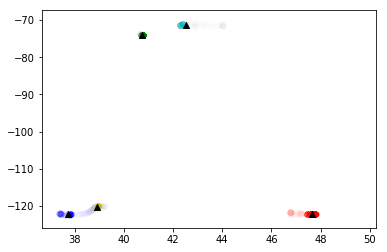

In [7]:
from matplotlib import pyplot as plt

cluster_colors = ['r', 'g', 'b', 'c', 'y']

for i in range(n_clusters):
    plt.scatter(loc_data[loc_data['cluster']==i]['latitude'],
                loc_data[loc_data['cluster']==i]['longitude'],
                alpha=0.005, c=cluster_colors[i])
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c='black', marker='^')
plt.savefig('./exploration/fig-lat-lon-2d.png', format='png')
plt.show()

In [8]:
clusters = {}
for i in range(n_clusters):
    clusters[i] = loc_data[loc_data['cluster'] == i]
    
cluster_sizes = [len(x) for _, x in clusters.items()]
print(cluster_sizes)

[8344, 408, 548, 322, 284]


center=40.74688682745098,-74.05754189950981 (255 Hutton St, Jersey City, NJ 07307, USA)


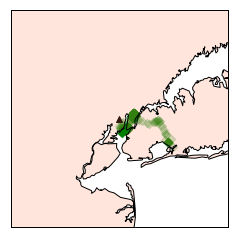

In [9]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import find_address

# Plot cluster i in a map (plotting warm-up! :)
i = 1

lats = clusters[i]['latitude'].values
lons = clusters[i]['longitude'].values

map = Basemap(projection='aeqd',
              lat_0=cluster_centers[i][0], lon_0=cluster_centers[i][1],
              width=1000*100, height=1000*100,
              resolution = 'h',
              # llcrnrlon=min(clusters[i]['longitude']),
              # llcrnrlat=min(clusters[i]['latitude']),
              # urcrnrlon=max(clusters[i]['longitude']),
              # urcrnrlat=max(clusters[i]['latitude'])
             )

map.drawmapboundary(fill_color='white')
map.fillcontinents(color='coral',lake_color='aqua', alpha=0.2)
map.drawcoastlines()

x, y = map(lons, lats)
map.scatter(x, y, marker='D', color=cluster_colors[i], alpha=0.2)

x, y = map(cluster_centers[i][1], cluster_centers[i][0])
map.scatter(x, y, marker='^', color='black')

loc_address = find_address.get_address(cluster_centers[i][0], cluster_centers[i][1])
title = 'center={},{} ({})'.format(cluster_centers[i][0], cluster_centers[i][1], loc_address)
print(title)
# plt.title(title)
plt.show()

center=47.65569203238255,-122.13006269447509 ==> (15722 NE 53rd St, Redmond, WA 98052, USA)
center=40.74688682745098,-74.05754189950981 ==> (255 Hutton St, Jersey City, NJ 07307, USA)
center=37.73064549543796,-122.16183264744525 ==> (201-213 Leo Ave, San Leandro, CA 94577, USA)
center=42.53186271645963,-71.27615696397517 ==> (Northwest Expy, Billerica, MA, USA)
center=38.91116934929577,-120.16368754683099 ==> (Pacific Crest Trail, South Lake Tahoe, CA 96150, USA)


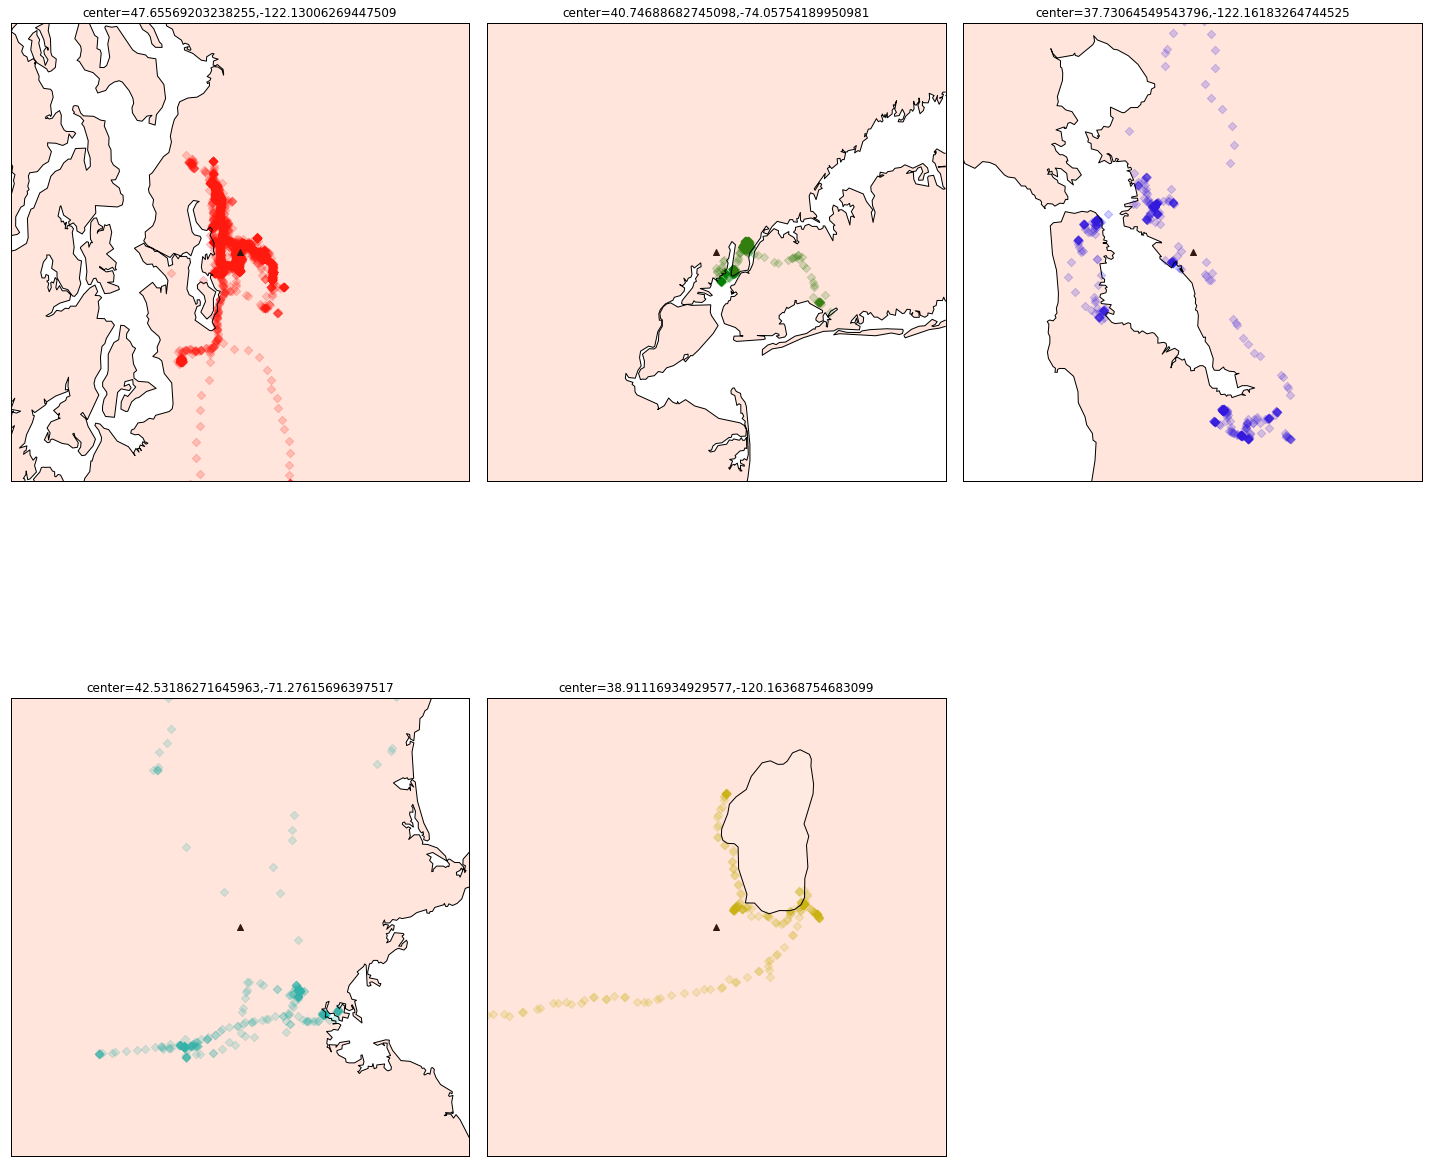

In [10]:
import math

# Plot the user's movements in separate maps for each cluster center

plt.cla()
plt.clf()

fig_columns = 3
fig, axes = plt.subplots(math.ceil(n_clusters/fig_columns), fig_columns, squeeze=False)


fig.set_size_inches(20, 20)
for i in range(len(axes) * len(axes[0])):
    ax = axes[int(i/fig_columns)][i%fig_columns]
    
    if i >= n_clusters:
        fig.delaxes(ax)
    else:
        ax.autoscale()
        loc_address = find_address.get_address(cluster_centers[i][0], cluster_centers[i][1])
        print('center={},{} ==> ({})'.format(cluster_centers[i][0], cluster_centers[i][1], loc_address))
        ax.set_title('center={},{}'.format(cluster_centers[i][0], cluster_centers[i][1]))
        map = Basemap(projection='aeqd',
                      lat_0=cluster_centers[i][0], lon_0=cluster_centers[i][1],
                      width=1000*100, height=1000*100,
                      resolution = 'h',
                      ax=ax)

        map.drawmapboundary(fill_color='white', ax=ax)
        map.fillcontinents(color='coral', lake_color='white', alpha=0.2, ax=ax)
        map.drawcoastlines(ax=ax)

        x, y = map(clusters[i]['longitude'].values, clusters[i]['latitude'].values)
        _ = map.scatter(x, y, marker='D', color=cluster_colors[i], alpha=0.2)

        x, y = map(cluster_centers[i][1], cluster_centers[i][0])
        _ = map.scatter(x, y, marker='^', color='black')

plt.tight_layout()
plt.savefig('./exploration/fig-movement-maps.png', format='png')
plt.show()

In [11]:
# See geopy doc at: https://github.com/geopy/geopy
from geopy.distance import vincenty
from geopy.distance import great_circle

# Compute the derived features 'time_spent' and 'dist_travelled' based 
# upon successive data points (sorted over time).

movements = [0]
timespans = []
for i in range(0, len(loc_data)-1): # len(loc_data)-1):
    p0 = loc_data.iloc[i][['latitude', 'longitude', 'timestampMs']]
    p1 = loc_data.iloc[i+1][['latitude', 'longitude', 'timestampMs']]
    # d_line = vincenty((p0['latitude'], p0['longitude']), (p1['latitude'], p1['longitude']))
    d_crl = great_circle((p0['latitude'], p0['longitude']), (p1['latitude'], p1['longitude']))
    timespans.append(int(p0['timestampMs']) - int(p1['timestampMs']))
    movements.append(d_crl.m)

timespans.append(0)
loc_data['time_spent'] = timespans
loc_data['dist_travelled'] = movements

In [12]:
# Parameters determining user's stationary criteria
MOVEMENT_THRESHOLD=250
TIMESPAN_THRESHOLD=5*60*1000

loc_data['stationary'] = (loc_data['time_spent']>TIMESPAN_THRESHOLD) & (loc_data['dist_travelled']<MOVEMENT_THRESHOLD)
print(loc_data[:20][['timestampMs', 'latitude', 'longitude', 'time_spent', 'dist_travelled', 'stationary']])

      timestampMs   latitude   longitude  time_spent  dist_travelled  \
0   1509141279901  47.637362 -122.135648     7028920        0.000000   
1   1509134250981  47.637290 -122.135411     1634531       19.518370   
2   1509132616450  47.637069 -122.132981     3897382      183.720143   
3   1509128719068  47.637305 -122.135734      321071      208.011091   
4   1509128397997  47.637778 -122.134946      204002       79.075908   
5   1509128193995  47.636363 -122.139635      125999      384.990857   
6   1509128067996  47.631899 -122.184322      127000     3385.954879   
7   1509127940996  47.654424 -122.187356      124003     2515.642645   
8   1509127816993  47.686208 -122.182915      130999     3550.783552   
9   1509127685994  47.695243 -122.180760      142000     1017.789240   
10  1509127543994  47.698426 -122.180275      150002      355.885479   
11  1509127393992  47.704819 -122.180026      133000      711.392896   
12  1509127260992  47.732308 -122.188568      126000     3123.55

In [13]:
stationary_loc_data = loc_data[loc_data['stationary']].reset_index()
stationary_loc_data['shortTimestampHs'] = (stationary_loc_data['timestampMs'].astype(int) - min(stationary_loc_data['timestampMs'].astype(int)))/(1000*60*60)

In [14]:
sum(loc_data['stationary'])

3463

In [15]:
len(stationary_loc_data)

3463

In [16]:
import csv

LOC_LOOKUP_CACHE_FILEPATH = 'exploration/.location_lookup_cache.csv'
LOC_LOOKUP_CACHE_DELIMITER = ','
LOC_LOOKUP_CACHE_DEBUG_MODE = False
LOC_LOOKUP_CACHE_FORMAT = ['latitude', 'longitude' , 'location_name']
LOC_LOOKUP_CACHE_PRECISION_FORMAT = '{:.6f}'

def load_location_cache(cache_filepath=LOC_LOOKUP_CACHE_FILEPATH, delimiter=LOC_LOOKUP_CACHE_DELIMITER):
    '''Loads the location data from a file (csv format: latitude,longitude,location_name) and returns
    it as a dictionary with (latitude,longitude) as key and location_name as value.'''
    try:
        loc_cache = dict()
        with open(cache_filepath, 'r', newline='') as cache_file:
            reader = csv.DictReader(cache_file)
            for loc in reader:
                loc_lat_str = loc['latitude']
                loc_lon_str = loc['longitude']
                loc_name_str = loc['location_name']
                if LOC_LOOKUP_CACHE_DEBUG_MODE:
                    print('{},{},{}'.format(loc_lat_str, loc_lon_str, loc_name_str))
                loc_cache[(loc_lat_str, loc_lon_str)] = loc_name_str
            return loc_cache
    except FileNotFoundError as x:
        print(x)
        return None
    except y:
        print(y)
        return None

def save_location_cache(loc_cache, cache_filepath=LOC_LOOKUP_CACHE_FILEPATH, delimiter=LOC_LOOKUP_CACHE_DELIMITER):
    '''Stores the location data in a file (csv format: latitude,longitude,location_name).'''
    try:
        with open(cache_filepath, 'w') as cache_file:
            writer = csv.DictWriter(cache_file, fieldnames=LOC_LOOKUP_CACHE_FORMAT)
            writer.writeheader()
            for loc in loc_cache.items():
                loc_lat = loc[0][0]
                loc_lat_str = loc_lat if isinstance(loc_lat, str) else LOC_LOOKUP_CACHE_PRECISION_FORMAT.format(loc_lat)
                loc_lon = loc[0][1]
                loc_lon_str = loc_lon if isinstance(loc_lon, str) else LOC_LOOKUP_CACHE_PRECISION_FORMAT.format(loc_lon)
                loc_name_str = loc[1]
                if LOC_LOOKUP_CACHE_DEBUG_MODE:
                    print('{},{},{}'.format(loc_lat_str, loc_lon_str, loc_name_str))
                writer.writerow({'latitude': loc_lat_str, 'longitude': loc_lon_str, 'location_name': loc_name_str})
            return True
    except x:
        print(x)
        return False

In [17]:
def update_loc_cache(loc_data, loc_dict=None):
    '''Returns a dictionary of looked up location_names with (latitude,longitude) as key
    for all data points in loc_data.
    '''
    if loc_dict is None:
        loc_dict = load_location_cache()
        if loc_dict is None:
            loc_dict = dict()
    for i in range(len(loc_data)):
        lat, lon, stationary, time_spent, dist_travelled = \
            loc_data.iloc[i][['latitude', 'longitude', 'stationary', 'time_spent', 'dist_travelled']]
        
        loc_key, loc_name = lookup_location_name((lat.astype(float), lon.astype(float)), loc_dict)
        loc_dict[loc_key] = loc_name
        
        if LOC_LOOKUP_CACHE_DEBUG_MODE:
            print('{}. {} {} @ {},{} - {}mins, {}meters'.format(i, '*' if stationary else ' ', loc_name, loc_lat_str, loc_lon_str, int(time_spent/60000), int(dist_travelled)))

    save_location_cache(loc_dict)
    return loc_dict

def lookup_location_name(loc_lat_lon, loc_dict):
    '''Looks up the location name using Google maps API (also lowers the precision
    of latitude and longitude to LOC_LOOKUP_CACHE_PRECISION_FORMAT decimals).
    '''
    loc_lat_str = LOC_LOOKUP_CACHE_PRECISION_FORMAT.format(loc_lat_lon[0])
    loc_lon_str = LOC_LOOKUP_CACHE_PRECISION_FORMAT.format(loc_lat_lon[1])
    loc_key = (loc_lat_str, loc_lon_str)
    
    if(loc_key in loc_dict.keys()):
        loc_name = loc_dict[loc_key]
    else:
        loc_name = get_place(latitude=loc_lat_str, longitude=loc_lon_str)
    
    loc_dict[loc_key] = loc_name
    return loc_key, loc_name

In [18]:
BATCH_SIZE = 100

# Looking up 3000 location names using Google Maps API takes a lot of time!
# The code below is intended to act as a cache and store the results incrementally.
# This is done in batches of size 100. At the end of each batch the result is
# persisted in a file. So feel free to interrupt the processing if you got bored
# (you can later restart from where you left off)!

all_loc_dict = load_location_cache()
if all_loc_dict is None:
    all_loc_dict = dict()
for i in range(len(stationary_loc_data) // BATCH_SIZE):
    loc_dict = update_loc_cache(stationary_loc_data[i*BATCH_SIZE:(i+1)*BATCH_SIZE], loc_dict=all_loc_dict)
    print('Updated loc cache in range {}-{} out of {}. Total cache size: {}.'.format(i*BATCH_SIZE, (i+1)*BATCH_SIZE-1, len(stationary_loc_data), len(all_loc_dict)))

update_loc_cache(stationary_loc_data[-1*BATCH_SIZE:], loc_dict=all_loc_dict)
print('Updated last {} entries. Total cache size: {}.'.format(BATCH_SIZE, len(all_loc_dict)))

Updated loc cache in range 0-99 out of 3463. Total cache size: 5845.
Updated loc cache in range 100-199 out of 3463. Total cache size: 5845.
Updated loc cache in range 200-299 out of 3463. Total cache size: 5845.
Updated loc cache in range 300-399 out of 3463. Total cache size: 5845.
Updated loc cache in range 400-499 out of 3463. Total cache size: 5845.
Updated loc cache in range 500-599 out of 3463. Total cache size: 5845.
Updated loc cache in range 600-699 out of 3463. Total cache size: 5845.
Updated loc cache in range 700-799 out of 3463. Total cache size: 5845.
Updated loc cache in range 800-899 out of 3463. Total cache size: 5845.
Updated loc cache in range 900-999 out of 3463. Total cache size: 5845.
Updated loc cache in range 1000-1099 out of 3463. Total cache size: 5845.
Updated loc cache in range 1100-1199 out of 3463. Total cache size: 5845.
Updated loc cache in range 1200-1299 out of 3463. Total cache size: 5845.
Updated loc cache in range 1300-1399 out of 3463. Total cache

In [19]:
len(loc_dict)

5845

In [20]:
import datetime

def convert_timestamp_to_date_literals(ts):
    '''Returns separate derived features (year, month, hour, partofday, weekday)
    based on the timestamp value.
    '''
    dt = datetime.datetime.fromtimestamp(ts.astype(int)/1000)
    partofday = 'morning' if (dt.hour<11 and dt.hour>6) else 'afternoon' if (dt.hour>=11 and dt.hour<18) else 'evening'
    return dt.year, dt.month, dt.hour, partofday, dt.weekday()

stationary_loc_data['loc_name'] = stationary_loc_data[['latitude', 'longitude']].apply(
    lambda loc: all_loc_dict[(LOC_LOOKUP_CACHE_PRECISION_FORMAT.format(loc[0]), LOC_LOOKUP_CACHE_PRECISION_FORMAT.format(loc[1]))],
    axis=1)

stationary_loc_data['datetime'] = stationary_loc_data[['timestampMs']].apply(
    lambda ts: convert_timestamp_to_date_literals(ts),
    axis=1)

# Augment the data set with 'year', 'month', 'partofday' and 'weekday' features
stationary_loc_data[['year', 'month', 'hour', 'partofday', 'weekday']] = stationary_loc_data['datetime'].apply(pd.Series)

In [21]:
location_names = [loc_name[0] for loc_name in stationary_loc_data[['loc_name']].values]

In [22]:
len(location_names)

3463

In [23]:
loc_time_spent_dict = {loc_name: 0 for loc_name in stationary_loc_data['loc_name']}
loc_visitation_count_dict = {loc_name: 0 for loc_name in stationary_loc_data['loc_name']}
for row in stationary_loc_data[['loc_name', 'time_spent']].itertuples():
    loc_name = row[1]
    time_spent = row[2]
    loc_time_spent_dict[loc_name] += time_spent
    loc_visitation_count_dict[loc_name] += 1

In [24]:
# Amount of time that user has to spend at a location to be considered frequent
FREQUENT_LOC_TIME_THRESHOLD = 10*60*1000

# Number of visits to a location to be considered frequently-visited
FREQUENT_LOC_COUNT_THRESHOLD = 10

frequent_locs = [loc_name for loc_name, loc_visitation_count in loc_visitation_count_dict.items() if loc_visitation_count>FREQUENT_LOC_COUNT_THRESHOLD]
long_spent_locs = [loc_name for loc_name, loc_time_spent in loc_time_spent_dict.items() if loc_time_spent>FREQUENT_LOC_TIME_THRESHOLD]

In [25]:
def get_frequent_location_stat(frequent_locs, stationary_loc_data):
    '''Returns statistics about the number of visits and time spent at each location.
    '''
    stats = pd.DataFrame(columns=['loc_name', 'total_visits', 'total_time_spent'])
    for loc_name in frequent_locs:
        filtered_loc_data = stationary_loc_data['loc_name']==loc_name
        total_visits = sum(filtered_loc_data)
        total_time_spent = sum(stationary_loc_data[filtered_loc_data]['time_spent'])
        stats = stats.append({'loc_name': loc_name, 'total_visits': total_visits, 'total_time_spent': total_time_spent}, ignore_index=True)
    return stats

frequent_location_stats = get_frequent_location_stat(frequent_locs, stationary_loc_data)

In [26]:
frequent_location_stats.sort_values(['total_visits', 'total_time_spent', 'loc_name'], ascending=False, axis=0, inplace=True)
frequent_location_stats

,loc_name,total_visits,total_time_spent
0,Your Massage Mattersi,1314,3755077238
10,Ashcott Highlands,780,2882424398
4,Microsoft Building 22,476,1624225635
9,Microsoft Cafe 40 (employees only),86,106640787
7,Microsoft Building 41,28,92602420
5,Microsoft Building 43,23,48955960
11,Joseph Neto Painting,20,208154987
2,Drucker Joel,20,170215884
8,Overlake Terrace Retirement Community,20,98003705
12,Microsoft Field 5,16,7337682


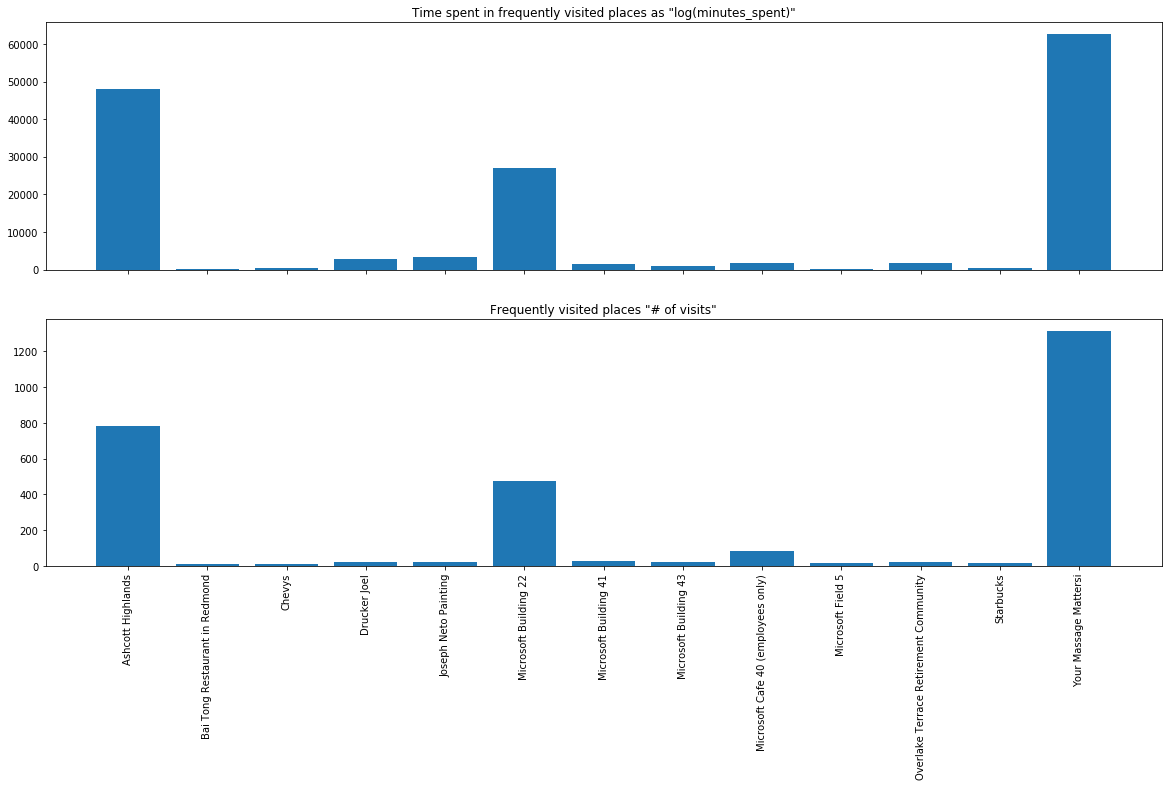

In [27]:
from matplotlib import pyplot as plt
from math import log

# Plot the time spent and frequency of visits to frequently-visited stationary locations 

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=True)

ax1.bar(frequent_location_stats['loc_name'].tolist(),
        frequent_location_stats['total_time_spent'].apply(lambda t: (t/1000/60)).tolist())
ax1.set_xticklabels([])
title = ax1.set_title('Time spent in frequently visited places as "log(minutes_spent)"')


ax2.bar(frequent_location_stats['loc_name'].tolist(),
        frequent_location_stats['total_visits'].apply(lambda v: (v)).tolist())
plt.xticks(rotation=90)
title = ax2.set_title('Frequently visited places "# of visits"')

plt.savefig('./exploration/fig-frequent-locations.png', format='png')
plt.show()

In [28]:
frequent_stationary_loc_data = stationary_loc_data[stationary_loc_data['loc_name'].isin(frequent_locs)]
len(frequent_stationary_loc_data)

2820

In [29]:
stationary_loc_data.describe()

,index,accuracy,altitude,heading,velocity,verticalAccuracy,latitude,longitude,cluster,time_spent,dist_travelled,shortTimestampHs,year,month,hour,weekday
count,3463.000000,3463.000000,3065.000000,535.000000,2311.000000,3065.000000,3463.000000,3463.000000,3463.000000,3.463000e+03,3463.000000,3463.000000,3463.0,3463.000000,3463.000000,3463.000000
mean,5360.748195,49.125902,128.720392,190.973832,0.207270,14.207178,46.894170,-119.426278,0.217153,2.958926e+06,42.097050,1753.143872,2017.0,7.673405,12.830494,2.847820
std,2710.767022,174.566224,241.587612,102.833413,0.944274,16.530132,2.410666,11.130387,0.733907,6.101932e+06,53.908481,970.271790,0.0,1.375449,6.327512,2.004962
min,0.000000,0.000000,-126.000000,0.000000,0.000000,2.000000,37.363612,-122.447534,0.000000,3.000030e+05,0.000000,0.000000,2017.0,5.000000,0.000000,0.000000
25%,3001.500000,10.000000,68.000000,106.000000,0.000000,6.000000,47.637319,-122.200977,0.000000,4.012345e+05,10.008949,1011.108715,2017.0,7.000000,9.000000,1.000000
50%,5460.000000,30.000000,110.000000,195.000000,0.000000,10.000000,47.648504,-122.129648,0.000000,7.760550e+05,19.518370,1774.019166,2017.0,8.000000,12.000000,3.000000
75%,7743.500000,65.000000,126.000000,280.000000,0.000000,16.000000,47.672297,-122.070656,0.000000,2.427490e+06,45.238341,2509.103333,2017.0,9.000000,19.000000,5.000000
max,9903.000000,7467.000000,2792.000000,357.000000,14.000000,380.000000,47.834474,-71.015633,4.000000,6.317932e+07,249.647789,3724.832195,2017.0,10.000000,23.000000,6.000000


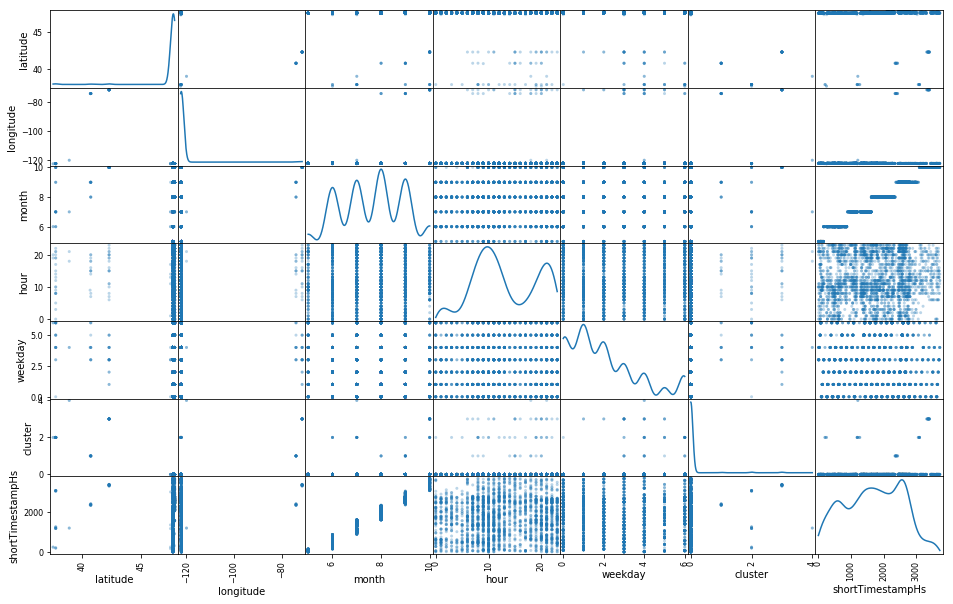

In [30]:
%matplotlib inline

# Check out correlation between various features

data_to_plot = frequent_stationary_loc_data[['latitude', 'longitude', 'month', 'hour', 'partofday', 'weekday', 'cluster', 'shortTimestampHs']]
_ = pd.scatter_matrix(data_to_plot, alpha=0.3, figsize=(16,10), diagonal='kde')

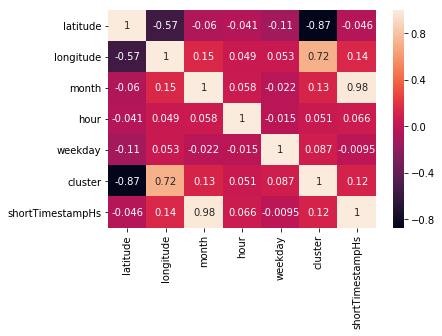

In [31]:
import seaborn as sns

# Nicer way to look at feature correlation using a heatmap!
_ = sns.heatmap(data_to_plot.corr(), annot=True)

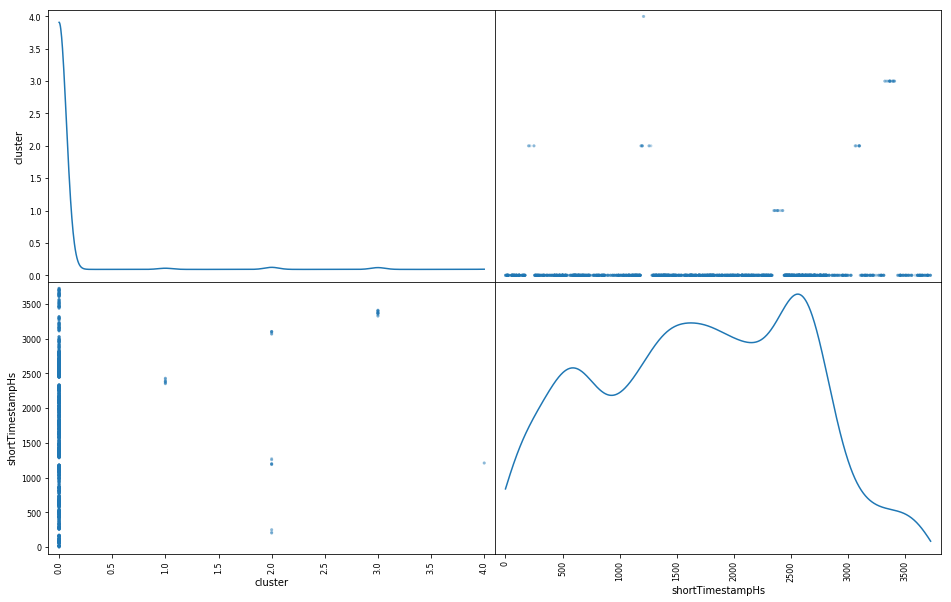

In [32]:
import matplotlib as mpl
%matplotlib inline

data_to_plot = frequent_stationary_loc_data[['cluster', 'shortTimestampHs']]
_ = pd.scatter_matrix(data_to_plot, alpha=0.3, figsize=(16,10), diagonal='kde', cmap=mpl.cm.cool)

In [33]:
frequent_stationary_loc_data.describe()

,index,accuracy,altitude,heading,velocity,verticalAccuracy,latitude,longitude,cluster,time_spent,dist_travelled,shortTimestampHs,year,month,hour,weekday
count,2820.000000,2820.000000,2552.000000,355.000000,1983.000000,2552.000000,2820.000000,2820.000000,2820.000000,2.820000e+03,2820.000000,2820.000000,2820.0,2820.000000,2820.000000,2820.000000
mean,5465.339716,43.926950,105.986677,195.430986,0.130610,14.187304,47.527542,-121.541634,0.045035,3.208824e+06,34.647871,1716.160310,2017.0,7.618085,12.463121,2.666312
std,2654.719969,163.561942,58.639413,101.127193,0.665259,15.770881,1.121640,5.346829,0.332299,6.462475e+06,48.892532,947.923503,0.0,1.349744,6.668323,1.998137
min,0.000000,4.000000,11.000000,0.000000,0.000000,2.000000,37.602778,-122.394643,0.000000,3.000030e+05,0.000000,0.000000,2017.0,5.000000,0.000000,0.000000
25%,3049.250000,10.000000,69.000000,116.500000,0.000000,6.000000,47.639209,-122.200998,0.000000,4.019885e+05,9.272736,945.578982,2017.0,7.000000,8.000000,1.000000
50%,5511.500000,30.000000,116.000000,197.000000,0.000000,10.000000,47.648529,-122.132973,0.000000,8.043620e+05,16.968463,1742.572222,2017.0,8.000000,12.000000,2.000000
75%,7832.250000,55.000000,126.000000,283.000000,0.000000,16.000000,47.786636,-122.070709,0.000000,2.837992e+06,31.495949,2503.592280,2017.0,9.000000,19.000000,4.000000
max,9903.000000,7467.000000,1917.000000,357.000000,10.000000,192.000000,47.787337,-71.423320,4.000000,6.317932e+07,249.560726,3724.832195,2017.0,10.000000,23.000000,6.000000


In [34]:
frequent_stationary_loc_data.columns

Index(['index', 'accuracy', 'altitude', 'heading', 'timestampMs', 'velocity',
       'verticalAccuracy', 'latitude', 'longitude', 'cluster', 'time_spent',
       'dist_travelled', 'stationary', 'shortTimestampHs', 'loc_name',
       'datetime', 'year', 'month', 'hour', 'partofday', 'weekday'],
      dtype='object')

In [35]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.tree import DecisionTreeClassifier

random_state = 42

class LocationPredictor:
    '''Implements functionarlity to easily train and evaluate a decision tree
    classifer while taking care of tasks such as dataset splitting and accuracy
    and logloss metric computation.
    '''
    def __init__(self, one_hot_encode=False, random_state=random_state, min_samples_split=2, max_depth=None):
        self.enc = OneHotEncoder() if one_hot_encode else None
        self.clfr = DecisionTreeClassifier(random_state=random_state, min_samples_split=min_samples_split, max_depth=max_depth)
        self.random_state = random_state

    def train_classififer(self, X_train, y_train):
        _ = self.clfr.fit(X_train, y_train)
    
    def evaluate_classifier(self, X, y):
        if self.enc:
            X = self.enc.fit_transform(X)
            y = y
        else:
            X = X
            y = y

        X_train, X_test, y_train, y_test = train_test_split(X,
                                                            y,
                                                            test_size=0.2,
                                                            random_state=self.random_state)
        self.train_classififer(X_train, y_train)

            
        pred_prob = self.clfr.predict_proba(X_test)
        pred = self.clfr.predict(X_test)
        return accuracy_score(y_test, pred), log_loss(y_test, pred_prob)

def report_results(loc_data, feature_list, one_hot_encode, random_state=random_state, min_samples_split=2, max_depth=None):
    '''Prints out a report of accuracy and log-loss score of a training using a
    dataset and selected feature list, with or without one-hot encoding of data.
    '''
    loc_predictor = LocationPredictor(one_hot_encode, random_state=random_state, min_samples_split=min_samples_split, max_depth=max_depth)
    accuracy, logloss = loc_predictor.evaluate_classifier(loc_data[feature_list],
                                                          loc_data[['loc_name']])

    print('Features: {}'.format(feature_list))
    print('OneHotEnc: {}'.format(one_hot_encode))
    print('Accuracy: {}'.format(accuracy))
    print('Log loss: {}'.format(logloss))
    
    return loc_predictor, accuracy, logloss

In [36]:
_ = report_results(frequent_stationary_loc_data, ['month', 'hour', 'weekday'], False)
_ = report_results(frequent_stationary_loc_data, ['cluster', 'month', 'hour', 'weekday'], False)
_ = report_results(frequent_stationary_loc_data, ['cluster', 'hour', 'weekday'], False)
_ = report_results(frequent_stationary_loc_data, ['cluster', 'year', 'month', 'hour', 'weekday'], False)
print()
_ = report_results(frequent_stationary_loc_data, ['month', 'hour', 'weekday'], True)
_ = report_results(frequent_stationary_loc_data, ['cluster', 'month', 'hour', 'weekday'], True)
_ = report_results(frequent_stationary_loc_data, ['cluster', 'hour', 'weekday'], True)
_ = report_results(frequent_stationary_loc_data, ['cluster', 'year', 'month', 'hour', 'weekday'], True)

Features: ['month', 'hour', 'weekday']
OneHotEnc: False
Accuracy: 0.7641843971631206
Log loss: 3.8450222494425765
Features: ['cluster', 'month', 'hour', 'weekday']
OneHotEnc: False
Accuracy: 0.7801418439716312
Log loss: 3.522742093403568
Features: ['cluster', 'hour', 'weekday']
OneHotEnc: False
Accuracy: 0.5691489361702128
Log loss: 2.5075645729138634
Features: ['cluster', 'year', 'month', 'hour', 'weekday']
OneHotEnc: False
Accuracy: 0.7819148936170213
Log loss: 3.46027414380167

Features: ['month', 'hour', 'weekday']
OneHotEnc: True
Accuracy: 0.7624113475177305
Log loss: 4.1425921593550505
Features: ['cluster', 'month', 'hour', 'weekday']
OneHotEnc: True
Accuracy: 0.774822695035461
Log loss: 3.8205208384856455
Features: ['cluster', 'hour', 'weekday']
OneHotEnc: True
Accuracy: 0.5726950354609929
Log loss: 2.3850866424354566
Features: ['cluster', 'year', 'month', 'hour', 'weekday']
OneHotEnc: True
Accuracy: 0.774822695035461
Log loss: 3.8205208384856455


In [37]:
import random

# Try different random states
all_accuracy = []
for random_state in [10, 20, 30, 40, 50, 60, 70, 80, 90]:
    print('Random state: {}'.format(random_state))
    _, accuracy, _ = report_results(frequent_stationary_loc_data, ['cluster', 'month', 'hour', 'weekday'],
                       False,
                       random_state=random_state)
    all_accuracy.append(accuracy)

print(sorted(all_accuracy))
print('Avg: {}'.format(np.mean(all_accuracy)))

Random state: 10
Features: ['cluster', 'month', 'hour', 'weekday']
OneHotEnc: False
Accuracy: 0.7677304964539007
Log loss: 3.840364431904318
Random state: 20
Features: ['cluster', 'month', 'hour', 'weekday']
OneHotEnc: False
Accuracy: 0.7606382978723404
Log loss: 4.065462163451058
Random state: 30
Features: ['cluster', 'month', 'hour', 'weekday']
OneHotEnc: False
Accuracy: 0.7801418439716312
Log loss: 3.8756759893151127
Random state: 40
Features: ['cluster', 'month', 'hour', 'weekday']
OneHotEnc: False
Accuracy: 0.7854609929078015
Log loss: 4.231978212716123
Random state: 50
Features: ['cluster', 'month', 'hour', 'weekday']
OneHotEnc: False
Accuracy: 0.799645390070922
Log loss: 3.039928296127035
Random state: 60
Features: ['cluster', 'month', 'hour', 'weekday']
OneHotEnc: False
Accuracy: 0.7854609929078015
Log loss: 3.5201629583281187
Random state: 70
Features: ['cluster', 'month', 'hour', 'weekday']
OneHotEnc: False
Accuracy: 0.75177304964539
Log loss: 3.6129684695171402
Random state:

Features: ['cluster', 'month', 'hour', 'weekday']
OneHotEnc: False
Accuracy: 0.7695035460992907
Log loss: 3.8863506167207245
Feature importance: [ 0.06441053  0.42239826  0.3210318   0.19215941]


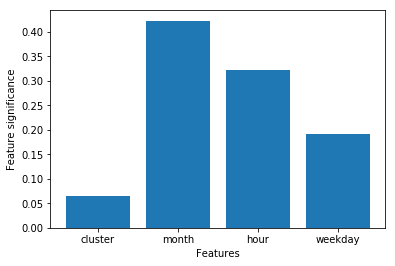

In [38]:
feature_list = ['cluster', 'month', 'hour', 'weekday']
predictor, accuracy, _ = report_results(frequent_stationary_loc_data,
                                        feature_list,
                                        False,
                                        random_state=random_state)

importance = predictor.clfr.feature_importances_
print('Feature importance: {}'.format(importance))
importance = pd.DataFrame(importance, index=feature_list, 
                          columns=["Importance"])

x = range(importance.shape[0])
y = importance.ix[:, 0]
plt.bar(x, y, align="center")
plt.xticks(range(len(feature_list)), feature_list)
plt.xlabel('Features')
plt.ylabel('Feature significance')

plt.savefig('./exploration/fig-feature-significance.png', format='png')
plt.show()

In [39]:
saved_predictor = predictor

In [40]:
feature_list = ['cluster', 'month', 'hour', 'weekday']
results=[]
for min_samples_split in [2, 5, 10]:
    for max_depth in [2, 4, 8, 16]:
        predictor, accuracy, _ = report_results(frequent_stationary_loc_data,
                                                feature_list,
                                                False,
                                                random_state=random_state,
                                                min_samples_split=min_samples_split,
                                                max_depth=max_depth)
        results.append('Min_sample_split:{:2d}, max_depth:{:2d}, accuracy:{:.2f}%'.format(min_samples_split, max_depth, accuracy*100))

print('\n'.join(results))

Features: ['cluster', 'month', 'hour', 'weekday']
OneHotEnc: False
Accuracy: 0.6648936170212766
Log loss: 1.0652223758879873
Features: ['cluster', 'month', 'hour', 'weekday']
OneHotEnc: False
Accuracy: 0.7677304964539007
Log loss: 0.9170361672184663
Features: ['cluster', 'month', 'hour', 'weekday']
OneHotEnc: False
Accuracy: 0.7783687943262412
Log loss: 1.9260927480961996
Features: ['cluster', 'month', 'hour', 'weekday']
OneHotEnc: False
Accuracy: 0.7695035460992907
Log loss: 3.8863506167207245
Features: ['cluster', 'month', 'hour', 'weekday']
OneHotEnc: False
Accuracy: 0.6648936170212766
Log loss: 1.0652223758879873
Features: ['cluster', 'month', 'hour', 'weekday']
OneHotEnc: False
Accuracy: 0.7677304964539007
Log loss: 0.9170361672184663
Features: ['cluster', 'month', 'hour', 'weekday']
OneHotEnc: False
Accuracy: 0.7783687943262412
Log loss: 1.8680306613485353
Features: ['cluster', 'month', 'hour', 'weekday']
OneHotEnc: False
Accuracy: 0.7783687943262412
Log loss: 3.4172151980606476


In [41]:
from random import random

class NaiiveLocationPredictor:
    
    MISSING_LOCATION = 'MISSING_LOCATION'
    
    def __init__(self, random_state=random_state, column_to_use='total_visits'):
        self.random_state = random_state
        self.column_to_use = column_to_use
        pass

    def train_classififer(self, X_train, y_train):
        total = sum(X_train[self.column_to_use])
        self.summary_stats = pd.DataFrame()
        self.summary_stats['loc_name'] = y_train[['loc_name']]
        self.summary_stats[self.column_to_use] = X_train[[self.column_to_use]]
        self.summary_stats.sort_values(by=self.column_to_use, inplace=True)
        self.summary_stats['cdf'] = self.summary_stats[self.column_to_use].cumsum() / total
    
    def classify(self):
        r = random()
        filtered = [tup[1] for tup in self.summary_stats[['loc_name', 'cdf']].sort_values(by='cdf').itertuples() if tup[2]<r]
        return filtered.pop() if len(filtered)>0 else NaiiveLocationPredictor.MISSING_LOCATION
    
    def evaluate_classifier(self, X, y):
        X_train, X_test, y_train, y_test = X, X, y, y
        self.train_classififer(X_train, y_train)
        pred = [self.classify() for _ in range(len(y_test))]
        return accuracy_score(y_test['loc_name'].tolist(), pred)

def report_naiive_results(num_runs):
    naiive_results = [NaiiveLocationPredictor().evaluate_classifier(frequent_location_stats.drop('loc_name', axis=1), frequent_location_stats[['loc_name']]) for i in range(num_runs)]
    print('Number of runs: {}'.format(num_runs))
    print('Min accuracy: {}'.format(np.min(naiive_results)))
    print('Avg accuracy: {}'.format(np.mean(naiive_results)))
    print('Max accuracy: {}'.format(np.max(naiive_results)))

In [42]:
report_naiive_results(num_runs=100)

Number of runs: 100
Min accuracy: 0.0
Avg accuracy: 0.07076923076923076
Max accuracy: 0.23076923076923078


In [49]:
from sklearn.tree import export_graphviz

best_min_samples_split = 5
best_max_depth = 8

predictor, accuracy, _ = report_results(frequent_stationary_loc_data,
                                        feature_list,
                                        False,
                                        random_state=random_state,
                                        min_samples_split=best_min_samples_split,
                                        max_depth=best_max_depth)
clfr = predictor.clfr
export_graphviz(clfr, out_file='./exploration/tree-{}-{}-{}.dot'.format(clfr.random_state, clfr.max_depth, clfr.min_samples_split))

Features: ['cluster', 'month', 'hour', 'weekday']
OneHotEnc: False
Accuracy: 0.7783687943262412
Log loss: 1.8680306613485353


In [48]:
print(random_state)


90
